## Yennie Jun Fundamentals of Social Data Science Summative

**TO DO** Make sure everything is in APA format

- [ ] references
- [ ] appendix - make sure even when I refer to appendix, make sure in APA
- [ ] justify the dates I chose

# Part 1

## Setup [500 words]

**Setup** 500 words, one Jupyter notebook cell: 

Lit review, set the scene, theory, research question, background research

The United States and South Korea experienced their first case of the COVID-19 virus on January 20, 2020 (Holsue, 2020; Lim, 2020). Despite this, the two countries have had vastly different experiences dealing with the virus. The US has experienced over ten million total cases and over 200,000 deaths related to the virus. In August, the US was found to account for 25 percent of COVID-19 cases and deaths in the world while comprising less than 5% of the global population (Florida Atlantic University, 2020). South Korea, on the other hand, managed to flatten the curve early on, emerging as a "model to emulate in fighting the pandemic" (You, 2020).

[ some more stuff and lit review ] 

The question I would like to answer is: Was there a significant difference in government response after first day of COVID-19 in each country, in terms of days taken before enacting certain measures (i.e. school closures, workplace closures, contact tracing). I will explore the quickness of government responses in after the first case of COVID-19 for each country. I will use January 20, 2020 as "first case of COVID-19." I will use the Government Response table from the Oxford COVID-19 Government REsponse Tracker (Mahdi, 2020).



## Data Analysis [750 words]

**Data Analysis** 750 words

Methods
- How are you going to start digging in?
- As well explained as possible, all the ways you will go about doing this "digging through" data wrangling
- All of the choices you will have to make (i.e. missing data)
- why did you make a certain decision? 
- One might think it justified to understand why a certain variable is more important to keep and certain variables more important to let go, how is it necessray for your explanation?

In [179]:
import os
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import psycopg2
from datetime import datetime
import re

sns.set()
sns.set_style("white")

### Literature Review
**[The Coronavirus Spring](https://www.edweek.org/ew/section/multimedia/the-coronavirus-spring-the-historic-closing-of.html)**
* Jan 29: first US cases emerge
* Feb 11: Teachers' unions take notice, calls for federal guidance for schools to handle covid
* mid Feb: temporary school closures
* Feb 25: CDC warning for schools
* Feb 27: first school shuts down in Washington (Bothell!)
* Mar 05: Some schools start to shift to distance learning (esp. Washington)
* Mar 11: Pandemic declared by WHO
* Mar 12: Ohio as first state to close all schools
* Mar 16: 27 states and territories close schools, more than half of all students in US impacted by school closures
* Mar 25: All US public school buildings are closed
* May 06: Nearly all states close schools (all by 2 states) for academic year


In [61]:
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19')
cur = conn.cursor()

In [157]:
# loading govtrack table for just the United States and Korea, in the first few months of covid
sql_command = """SELECT * FROM government_response\
    WHERE date < '2020-05-01' and (country = 'United States' or country='South Korea')\
    ORDER by date ASC"""
df_govtrack = pd.read_sql(sql_command, conn)

# to datetime
df_govtrack.date = pd.to_datetime(df_govtrack['date'])

# The number of dates since first case in the US
df_govtrack['days_since_first_infection'] = df_govtrack['date'] - datetime(2020, 1, 20)

From this graph we can see that Korea takes government action a lot quicker than the US. In fact, the US doesn't really start ramping up their response until early/mid March.

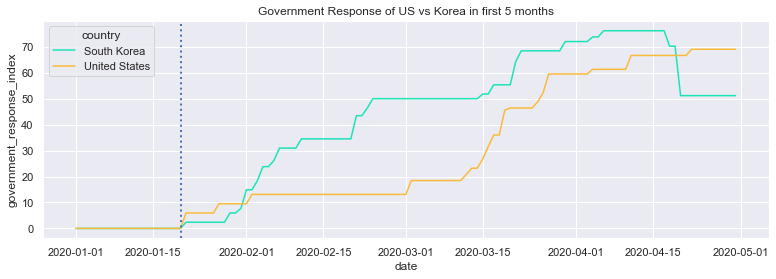

In [284]:
sns.set(rc={'figure.figsize':(13, 4)})
ax = sns.lineplot(data=df_govtrack[["date", "government_response_index", "country"]],
             x="date", y="government_response_index", hue="country", palette="turbo")
plt.title('Government Response of US vs Korea in first 5 months')

# Plot the "first day of contact"
ax.axvline(pd.to_datetime('2020-01-20'), color='b', linestyle=':', lw=2, label="First");

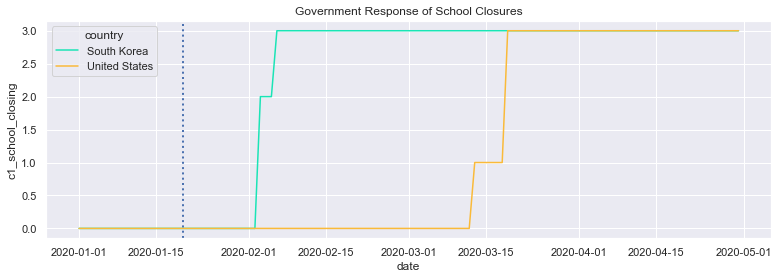

In [263]:
ax = sns.lineplot(data=df_govtrack, x="date", y="c1_school_closing", hue="country", palette="turbo")
plt.title('Government Response of School Closures');

# Plot the "first day of contact"
ax.axvline(pd.to_datetime('2020-01-20'), color='b', linestyle=':', lw=2, label="First");

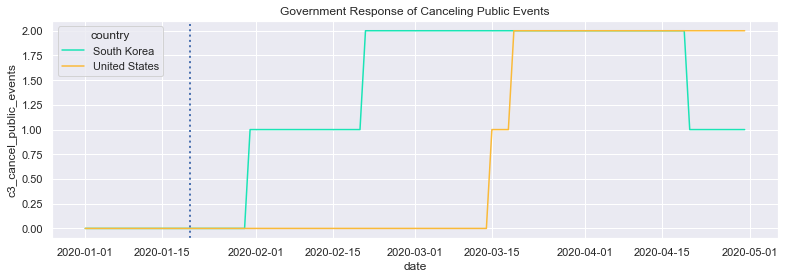

In [264]:
ax = sns.lineplot(data=df_govtrack, x="date", y="c3_cancel_public_events", hue="country", palette="turbo")
plt.title('Government Response of Canceling Public Events');

# Plot the "first day of contact"
ax.axvline(pd.to_datetime('2020-01-20'), color='b', linestyle=':', lw=2, label="First");

In [277]:
# Each of the c_xxxxx flags mentioned in the government response tracker
gov_flags = [re.search("c\d_[^flag]\w*", col).group() for col in df_govtrack.columns if re.match("c\d_[^flag]\w*", col)]
gov_flags.extend(["date", "days_since_first_infection", "country"])

# Get the containment and closure policies
df_melt = df_govtrack[gov_flags].sort_values(by="date")\
    .melt(id_vars=["date", "days_since_first_infection", "country"])\
    .dropna()

In [278]:
# Now we can see the first dates that the US started implementing controls
# So we can see that most of the restrictions started as 1 (recommended closure) then jumped
# to 2 or 3 (required closure) within a few days


df_melt[df_melt.value!=0].groupby(['variable', 'country', 'value']).first()

date  \
variable                             country       value              
c1_school_closing                    South Korea   2     2020-02-03   
                                                   3     2020-02-06   
                                     United States 1     2020-03-13   
                                                   3     2020-03-19   
c2_workplace_closing                 South Korea   1     2020-02-24   
                                                   2     2020-03-22   
                                                   3     2020-04-06   
                                     United States 1     2020-03-12   
                                                   2     2020-03-16   
c3_cancel_public_events              South Korea   1     2020-01-31   
                                                   2     2020-02-21   
                                     United States 1     2020-03-15   
                                                   2     2020-03-19   
c4_restrictions_on_gatherings        South Korea   2     2020-02-21   
                                                   3     2020-03-22   
                                                   4     2020-04-04   
                                     United States 3     2020-03-17   
                                                   4     2020-03-27   
c5_close_public_transport            United States 2     2020-04-11   
c6_stay_at_home_requirements         South Korea   1     2020-02-23   
                                                   2     2020-03-21   
                                     United States 1     2020-03-25   
c7_restrictions_on_internal_movement South Korea   1     2020-02-23   
                                                   2     2020-03-21   
                                     United States 1     2020-03-16   
c8_international_travel_controls     South Korea   3     2020-02-04   
                                     United States 2     2020-02-02   
                                                   3     2020-03-02   

                                                         days_since_first_infection  
variable                             country       value                             
c1_school_closing                    South Korea   2                        14 days  
                                                   3                        17 days  
                                     United States 1                        53 days  
                                                   3                        59 days  
c2_workplace_closing                 South Korea   1                        35 days  
                                                   2                        62 days  
                                                   3                        77 days  
                                     United States 1                        52 days  
                                                   2                        56 days  
c3_cancel_public_events              South Korea   1                        11 days  
                                                   2                        32 days  
                                     United States 1                        55 days  
                                                   2                        59 days  
c4_restrictions_on_gatherings        South Korea   2                        32 days  
                                                   3                        62 days  
                                                   4                        75 days  
                                     United States 3                        57 days  
                                                   4                        67 days  
c5_close_public_transport            United States 2                        82 days  
c6_stay_at_home_requirements         South Korea   1                        34 days  
                                        

In [295]:
# This is looking at just ANY kind of response from the government.
# We can see that South Korea NEVER had any sort of public transportation restrictions
# The only thing the US seems to have beat Korea in was international travel restrictions LOL

df_melt[df_melt.value!=0].groupby(['variable', 'country']).first().unstack()\
    [["days_since_first_infection"]]

days_since_first_infection              
country                                             South Korea United States
variable                                                                     
c1_school_closing                                       14 days       53 days
c2_workplace_closing                                    35 days       52 days
c3_cancel_public_events                                 11 days       55 days
c4_restrictions_on_gatherings                           32 days       57 days
c5_close_public_transport                                   NaT       82 days
c6_stay_at_home_requirements                            34 days       65 days
c7_restrictions_on_internal_movement                    34 days       56 days
c8_international_travel_controls                        15 days       13 days

In [297]:
# So we can see here that, on average across all of the eight government repsonse variables,
# the US took twice as long to respond than South Korea. LOL!

df_melt[df_melt.value!=0].groupby(['variable', 'country']).first().unstack()\
    [["days_since_first_infection"]].mean().unstack(0)

,days_since_first_infection
country,
South Korea,25 days 00:00:00
United States,54 days 03:00:00


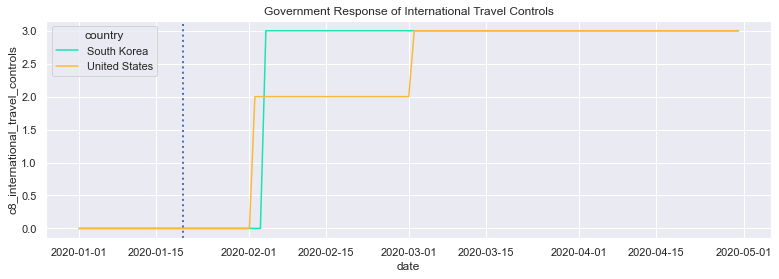

In [349]:
ax = sns.lineplot(data=df_govtrack, x="date", y="c8_international_travel_controls", hue="country", palette="turbo")
plt.title('Government Response of International Travel Controls');

# Plot the "first day of contact"
ax.axvline(pd.to_datetime('2020-01-20'), color='b', linestyle=':', lw=2, label="First");

### Limitations and Future Work

Limitations
* It is possible the data is not entirely accurate especially early on in the covid days
* Are limited in terms of "government response" nuance, because we don't know exaclty what KIND of response, and also, someone handlabeled these responses on a scale of 0 to 3 or 4... so, it doesn't say that much in terms of what kind of response, we only know general category of response
* 

Future Work
* Looking at more countries, not just these two
* Looking at the second half of the year, how the responses changed ... did they end up normalizing?

Conculsions
* US response to covid severely lagged behind Korea's - twice as much! While on average (across the eight different government measures) Korea responded within 25 days of the first covid case, US responded within an average of 54 days. Even better for comparison was the fact that both countries had the first COVID case on the same day.

In [ ]:
I am looking at covid data and i am looking 
for each country trying to compare how fast each government response was
so, starting with first covid date/case, and then the first government response 
this could be school closure, work closure, public transport closure, etc
these measures are captured in the oxford covid database so i am using taht 

# Part 2

TO DO: Fix the merge, because i think some countries are being dropped

Building on above, I'd like to examine average amount of days it takes for a country to respond to covid
And I'd like to ask the question: `Does a country's democracy index affect its quickness to reponse? Is there a correlation between democracy index and ... fastness of response?`

Two questions:
* Does democracy index affect country's fastness to response
* Does GHS (global health index) predict how fast a country would have responded to covid
* looks like...no!

I will be using the 2019democracy index calculated by the Economist Intelligence Unit (The Economist Intelligence Unit, 2019). I will have scraped it from Wikipedia, though.

cite this https://journals.sagepub.com/doi/full/10.1177/2319714520928884
They say democracy had better response to covid. but my results seem different

* https://www.theatlantic.com/ideas/archive/2020/02/why-democracies-are-better-fighting-outbreaks/606976/ pro democracy
* lot of info here https://carnegieendowment.org/2020/03/31/do-authoritarian-or-democratic-countries-handle-pandemics-better-pub-81404 "Authoritarian and democratic governments both have mixed records when it comes to pandemic response"
* https://www.chathamhouse.org/2020/05/why-democracies-do-better-surviving-pandemics

cite [this](https://www.semanticscholar.org/paper/Statistical-Classification-of-Democracy-Index-of-of-Bashar-Tsokos/c4df21e52c0225e0946321270d6bbc798f9f5924) and talk about some issues with democracy index



GHS index from here https://www.ghsindex.org/
* we already know ghs is NOT good indicator https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0239398

* But is GHS related to democracy, too?

In [442]:
from bs4 import BeautifulSoup
import requests

In [836]:
# Getting democracy index from Wikipedia page
response = requests.get("https://en.wikipedia.org/wiki/Democracy_Index")
soup = BeautifulSoup(response.text)

countries, scores, regimetypes, regions = [], [], [], []

for line in soup.find_all("table")[2].find_all("tr")[1:]:
    country = line.find("a").text
    score, regimetype = [a.text for a in line.find_all("b")]
    
    table_items = [t.text for t in line.find_all("td")]
    table_items = [i for i in table_items if 'Score:' not in i]
    
    countries.append(country)
    scores.append(score)
    regimetypes.append(regimetype)
    regions.append(table_items[-1].strip('\n'))
        
    if country == "North Korea": break

In [838]:
dem_index = pd.DataFrame([countries, scores, regimetypes, regions]).T
dem_index.columns=["country", "dem_score", "regimetype", "region"]
dem_index.dem_score = dem_index.dem_score.apply(float)
display(dem_index.head())

,country,dem_score,regimetype,region
0,Norway,9.87,Full democracy,Western Europe
1,Iceland,9.58,Full democracy,Western Europe
2,Sweden,9.39,Full democracy,Western Europe
3,New Zealand,9.26,Full democracy,Asia & Australasia
4,Finland,9.25,Full democracy,Western Europe


In [826]:
# Getting GHS index from https://www.ghsindex.org/
# In order to scrape, needed to check Networks tab in Chrome Dev Tools to see what graph api call they are making

query = {"query":"{\n countries(first: 1000) {\n    nodes {\n      title\n      termNames\n      slug\n      country_acf_field_group {\n        countryCode\n        overallScore\n        overallRank\n        __typename\n      }\n      __typename\n    }\n    __typename\n  }\n}\n"}
response = requests.post("https://www.ghsindex.org/wp/graphql", data=query)

countries, codes, scores = [], [], []

for country in response.json()['data']['countries']['nodes']:
    countries.append(country['title'])
    codes.append(country['country_acf_field_group']['countryCode'])
    scores.append(country['country_acf_field_group']['overallScore'])
    
ghs_index = pd.DataFrame([countries, codes, scores]).T
ghs_index.columns = ["country", "country_code", "ghs_score"]
ghs_index.ghs_score = ghs_index.ghs_score.apply(float)
display(ghs_index.head())

,country,country_code,ghs_score
0,St Vincent and The Grenadines,VCT,33
1,Zimbabwe,ZWE,38.2
2,Zambia,ZMB,28.7
3,Yemen,YEM,18.5
4,Vietnam,VNM,49.1


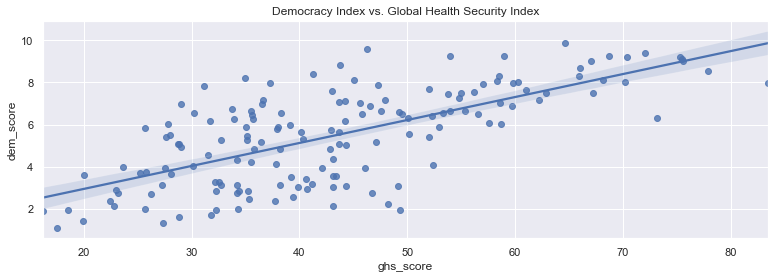

In [854]:
# For fun let's see if GHS and dem index are correlated
sns.regplot(data = dem_index.merge(ghs_index, on="country", how="left"), 
                x="ghs_score", 
                y="dem_score")

plt.title('Democracy Index vs. Global Health Security Index');

In [ ]:
# TO DO run OLS Regression

In [324]:
# Load government tracking data from OX COVID
sql_command_all = """SELECT * FROM government_response\
    WHERE date < '2020-04-01'\
    ORDER by date ASC"""
df_govtrack_all = pd.read_sql(sql_command_all, conn)

# to datetime
df_govtrack_all.date = pd.to_datetime(df_govtrack_all['date'])

In [301]:
# Load epidemiology data from OX COVID
sql_command_epi = """SELECT * FROM epidemiology WHERE date < '2020-04-01' ORDER by date DESC"""
df_epidemiology = pd.read_sql(sql_command_epi, conn)

# to datetime
df_epidemiology.date = pd.to_datetime(df_epidemiology['date'])

In [583]:
# Determine "first case of covid" for each country
first_confirmed = df_epidemiology[df_epidemiology.confirmed>0]\
    .sort_values(by="date")[["country", "date", "confirmed", "gid"]]\
    .groupby("country").first()

# the GIDs are in arrays; take them out
first_confirmed.gid = first_confirmed.gid.dropna().apply(lambda x: x[0])

# Drop all of the ones whose gid are none. These are continents (i.e. Africa, America, etc)
first_confirmed = first_confirmed[~first_confirmed.gid.isna()]

# Some GIDs are have extra numbers after it, get rid of them
first_confirmed.gid = first_confirmed.gid.apply(lambda x: re.search("(\w\w\w)",x).group(1))

In [898]:
# Determine government flags we want to use... we want c_xxxxxx
gov_flags = [re.search("c\d_[^flag]\w*", col).group() for col in df_govtrack.columns if re.match("c\d_[^flag]\w*", col)]
gov_flags.extend(["date", "country", "gid"])

# Dataframe with all of the government flags from above, melted
df_melt_all = df_govtrack_all[gov_flags]\
    .sort_values(by="date")\
    .melt(id_vars=["date", "country", "gid"])\
    .dropna()

# Merge in first confirmed date for each country
df_melt_all = df_melt_all.merge(first_confirmed, how="left", on=["gid"])\
    .rename(columns={"date_x": "date", "date_y": "first_confirmed_date"})\
    .drop(columns="confirmed")

# Calculate the number of days for each 
df_melt_all["response_since_first_infection"] = df_melt_all["date"] - df_melt_all["first_confirmed_date"]

In [958]:
df_govtrack_all[["government_response_index", "date", "country", "gid"]]\
    .sort_values(by="date").melt(id_vars=["date", "country", "gid"])\
    .dropna()

,date,country,gid,variable,value
0,2020-01-01,Iceland,ISL,government_response_index,0.00
1,2020-01-01,Liberia,LBR,government_response_index,0.00
2,2020-01-01,Tanzania,TZA,government_response_index,0.00
3,2020-01-01,Philippines,PHL,government_response_index,0.00
4,2020-01-01,Bulgaria,BGR,government_response_index,0.00
...,...,...,...,...,...
18468,2020-03-31,Brunei Darussalam,BRN,government_response_index,47.44
18469,2020-03-31,Spain,ESP,government_response_index,73.21
18470,2020-03-31,Ukraine,UKR,government_response_index,68.45
18471,2020-03-31,Tunisia,TUN,government_response_index,75.00


In [954]:
df_govtrack_all[gov_flags]\
    .sort_values(by="date")\
    .melt(id_vars=["date", "country", "gid"])\
    .dropna()

# looking at government response index

,date,country,gid,variable,value,first_confirmed_date,response_since_first_infection
0,2020-01-01,Iceland,ISL,c1_school_closing,0.0,2020-02-28,-58 days
1,2020-01-01,Liberia,LBR,c1_school_closing,0.0,2020-03-16,-75 days
2,2020-01-01,Tanzania,TZA,c1_school_closing,0.0,2020-03-16,-75 days
3,2020-01-01,Philippines,PHL,c1_school_closing,0.0,2020-01-30,-29 days
4,2020-01-01,Bulgaria,BGR,c1_school_closing,0.0,2020-03-08,-67 days
...,...,...,...,...,...,...,...
146323,2020-03-31,Brunei Darussalam,BRN,c8_international_travel_controls,4.0,2020-03-09,22 days
146324,2020-03-31,Spain,ESP,c8_international_travel_controls,4.0,2020-02-01,59 days
146325,2020-03-31,Ukraine,UKR,c8_international_travel_controls,4.0,2020-03-03,28 days
146326,2020-03-31,Tunisia,TUN,c8_international_travel_controls,4.0,2020-03-02,29 days


In [607]:
# Unfortunately, these countries just... don't exist according to Oxcovid database
# I suppose Hong Kong and Macao are "part of China"
# and the other places ... don't ... matter...???? So much for oxford being global and inclusive or something

df_melt_all[df_melt_all.first_confirmed_date.isna()].country.unique()

array(['Tajikistan', 'Vanuatu', 'Falkland Islands', 'Solomon Islands',
       'Yemen', 'Hong Kong', 'South Sudan', 'Malawi', 'Lesotho', 'Macao',
       'Pitcairn Islands', 'Turkmenistan'], dtype=object)

In [899]:
# We can see how each country has fared
df_melt_all[df_melt_all.value>1].groupby(['variable', 'country']).first()\
    .unstack()[["response_since_first_infection"]]

response_since_first_infection          \
country                                                 Afghanistan Albania   
variable                                                                      
c1_school_closing                                           19 days  0 days   
c2_workplace_closing                                        29 days  2 days   
c3_cancel_public_events                                      6 days  0 days   
c4_restrictions_on_gatherings                                   NaT  0 days   
c5_close_public_transport                                   33 days  4 days   
c6_stay_at_home_requirements                                30 days  4 days   
c7_restrictions_on_internal_movement                            NaT  4 days   
c8_international_travel_controls                            -1 days  2 days   

                                                                        \
country                              Algeria Andorra   Angola Anguilla   
variable                                                                 
c1_school_closing                    16 days 14 days   4 days -10 days   
c2_workplace_closing                 27 days 12 days   7 days   1 days   
c3_cancel_public_events              14 days     NaT   7 days   1 days   
c4_restrictions_on_gatherings        34 days     NaT   4 days   1 days   
c5_close_public_transport            27 days     NaT   7 days      NaT   
c6_stay_at_home_requirements         27 days     NaT   7 days   1 days   
c7_restrictions_on_internal_movement 27 days     NaT   7 days      NaT   
c8_international_travel_controls     18 days     NaT -43 days -11 days   

                                                                          ...  \
country                              Argentina   Aruba Australia Austria  ...   
variable                                                                  ...   
c1_school_closing                      18 days  3 days   59 days 20 days  ...   
c2_workplace_closing                   21 days  8 days   58 days 20 days  ...   
c3_cancel_public_events                13 days 16 days   53 days 15 days  ...   
c4_restrictions_on_gatherings          21 days 16 days   51 days 20 days  ...   
c5_close_public_transport              25 days     NaT       NaT     NaT  ...   
c6_stay_at_home_requirements           21 days 16 days       NaT 20 days  ...   
c7_restrictions_on_internal_movement   22 days 16 days   54 days 17 days  ...   
c8_international_travel_controls       13 days  4 days    7 days 13 days  ...   

                                                                           \
country                              Uruguay Uzbekistan Vanuatu Venezuela   
variable                                                                    
c1_school_closing                     1 days     1 days     NaT    2 days   
c2_workplace_closing                     NaT     1 days     NaT    2 days   
c3_cancel_public_events               0 days     1 days     NaT   -2 days   
c4_restrictions_on_gatherings            NaT     8 days     NaT    3 days   
c5_close_public_transport                NaT     1 days     NaT       NaT   
c6_stay_at_home_requirements             NaT    12 days     NaT   -1 days   
c7_restrictions_on_internal_movement     NaT     9 days     NaT   -1 days   
c8_international_travel_controls      0 days   -14 days     NaT   -2 days   

                                                                        \
country                              Venezuela, Bolivarian Republic of   
variable                                                                 
c1_school_closing                                               2 days   
c2_workplace_closing                                            2 days   
c3_cancel_public_events                                        -2 days   
c4_restrictions_on_gatherings                                   3 days   
c5_close_public_transport                                          NaT   
c6_stay_at_home_requ

In [901]:
# Leaving in NAs because then the average will be better
# To fill NAs fillna(pd.Timedelta(seconds=0))

# Here, looking at first response above a 1 score ... 1 is "recommended" whereas 2 is more stringent
all_countries_response_avg = df_melt_all[df_melt_all.value>1].groupby(['variable', 'country']).first()\
    .unstack()[["response_since_first_infection"]]\
    .mean().unstack(0)

# Extract just the number of "days" from the time detla
all_countries_response_avg["response_since_first_infection"] = all_countries_response_avg["response_since_first_infection"]\
    .apply(lambda a: a.days)

# Drop the countries with no data about confirmed cases
all_countries_response_avg = all_countries_response_avg[~all_countries_response_avg["response_since_first_infection"].isna()]
all_countries_response_avg.reset_index(inplace=True)

# Merge back in the date of the first case of covid
all_countries_response_avg = all_countries_response_avg.merge(first_confirmed.reset_index()[["country", "date"]], on="country")\
    .rename(columns={"date": "first_case"})

In [902]:
print("Countries with fastest responses")
display(all_countries_response_avg[all_countries_response_avg['response_since_first_infection'] > 1]\
    .sort_values(by='response_since_first_infection').head(10))

# We can see that countries with fastest response tended to have a later first-case

Countries with fastest responses


,country,response_since_first_infection,first_case
90,Laos,2.0,2020-03-24
1,Albania,2.0,2020-03-09
167,Uzbekistan,2.0,2020-03-15
141,Somalia,2.0,2020-03-16
101,Mauritius,2.0,2020-03-18
53,Eritrea,2.0,2020-03-21
33,Cayman Islands,2.0,2020-03-13
146,Sudan,3.0,2020-03-13
93,Liberia,3.0,2020-03-16
47,Djibouti,3.0,2020-03-18


In [903]:
print("Countries with slowest responses")
display(all_countries_response_avg[all_countries_response_avg['response_since_first_infection'] > 1]\
    .sort_values(by='response_since_first_infection').tail(10))

# Whereas those with slower responses tended to have earlier first cases

Countries with slowest responses


,country,response_since_first_infection,first_case
145,Sri Lanka,46.0,2020-01-27
8,Australia,47.0,2020-01-25
62,Germany,48.0,2020-01-27
163,United Arab Emirates,48.0,2020-01-27
165,United States,48.0,2020-01-20
31,Canada,50.0,2020-01-26
110,Nepal,51.0,2020-01-23
164,United Kingdom,59.0,2020-01-22
154,Thailand,63.0,2020-01-12
102,Mexico,71.0,2020-01-14


In [904]:
# Merge in democracy score and GHS index
df_merge = all_countries_response_avg.merge(dem_index, on="country").merge(ghs_index, on="country")

display(df_merge.head())

,country,response_since_first_infection,first_case,dem_score,regimetype,region,country_code,ghs_score
0,Afghanistan,19.0,2020-02-24,2.85,Authoritarian,Asia & Australasia,AFG,32.3
1,Albania,2.0,2020-03-09,5.89,Hybrid regime,Eastern Europe,ALB,52.9
2,Algeria,23.0,2020-02-25,4.01,Hybrid regime,Middle East & North Africa,DZA,23.6
3,Angola,0.0,2020-03-20,3.72,Authoritarian,Sub-Saharan Africa,AGO,25.2
4,Argentina,19.0,2020-02-27,7.02,Flawed democracy,Latin America,ARG,58.6


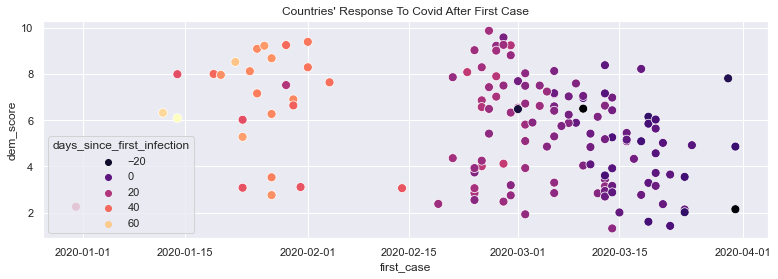

In [897]:
# Here we can see that countries with later first cases tended to respond faster after their first case
sns.scatterplot(data=df_merge, x="first_case", y="dem_score", hue="days_since_first_infection", s=80, palette="magma")
plt.title("Countries' Response To Covid After First Case");

In [ ]:
# Looking at democracy and relation to first response time

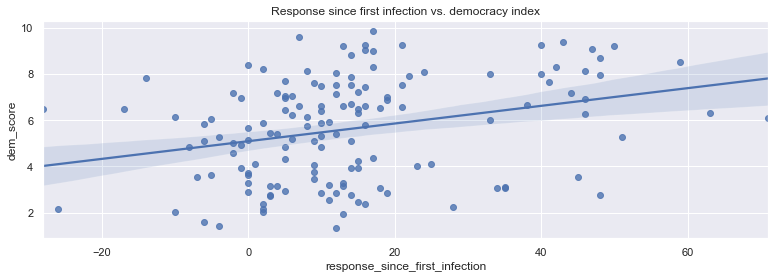

In [908]:
sns.regplot(x="response_since_first_infection", y="dem_score", data=df_merge)
plt.title('Response since first infection vs. democracy index');

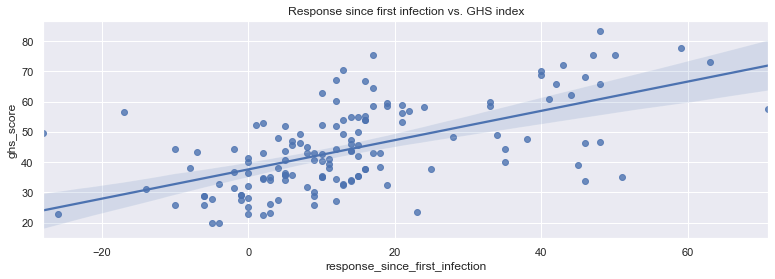

In [941]:
# The countries less prepared did a better job, in fact
sns.regplot(x="response_since_first_infection", y="ghs_score", data=df_merge)
plt.title('Response since first infection vs. GHS index');

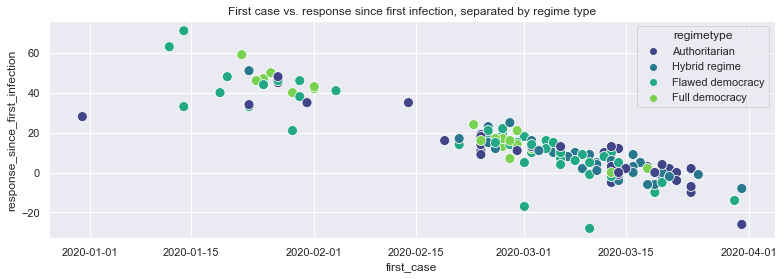

In [916]:
sns.scatterplot(x="first_case", y="response_since_first_infection", data=df_merge, hue="regimetype", s=100, palette="viridis")
plt.title("First case vs. response since first infection, separated by regime type");

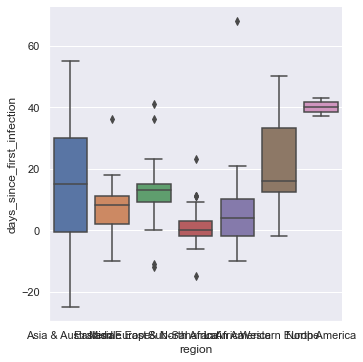

In [736]:
sns.catplot(x="region", y="days_since_first_infection", kind="box", data=df_merge)


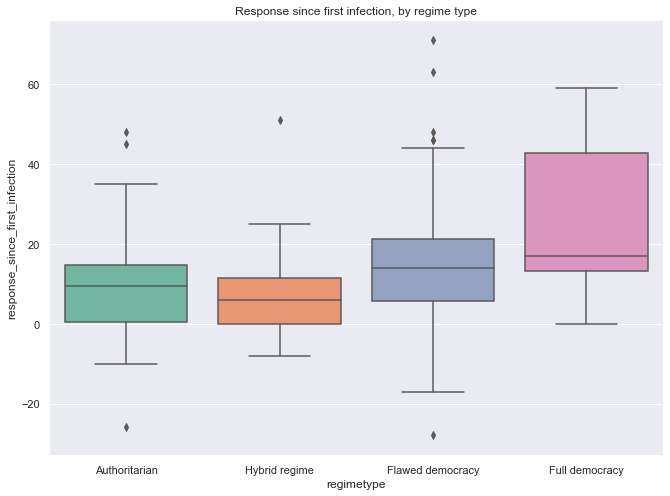

In [931]:
a4_dims = (11, 8)
fig, ax = plt.subplots(figsize=a4_dims)

g = sns.boxplot(ax=ax, x="regimetype", y="response_since_first_infection", data=df_merge, palette="Set2")
plt.title('Response since first infection, by regime type');

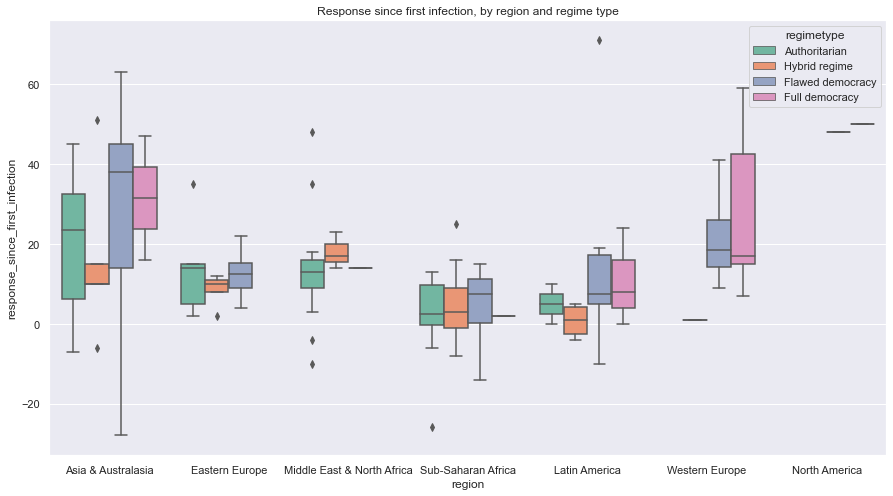

In [938]:
a4_dims = (15, 8)
fig, ax = plt.subplots(figsize=a4_dims)
g = sns.boxplot(ax=ax, x="region", y="response_since_first_infection", hue="regimetype", data=df_merge, palette="Set2")
plt.title('Response since first infection, by region and regime type');

In [ ]:
# In general we can see that Africa responded earlier... and North America later...

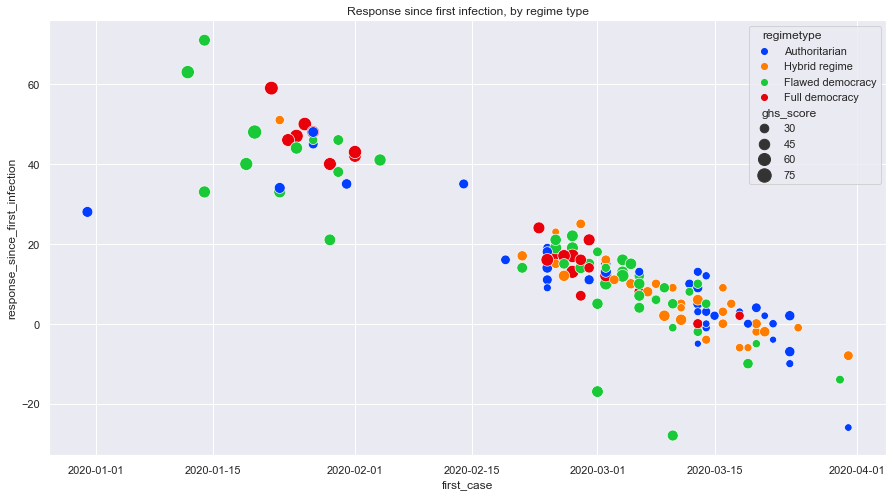

In [953]:
a4_dims = (15, 8)
fig, ax = plt.subplots(figsize=a4_dims)

g = sns.scatterplot(ax=ax, x="first_case", y="response_since_first_infection", data=df_merge, palette="bright",
                   hue="regimetype", size="ghs_score", sizes=(50, 200))
plt.title('Response since first infection, by regime type');

In [ ]:
# the more democratic you are the longer you take to respond? lol sort of ... but doesnt seem like good indicator

In [679]:
df_merge.groupby("region").mean()

,days_since_first_infection,score
region,,
Asia & Australasia,19.115385,5.828846
Eastern Europe,9.173913,5.695652
Latin America,6.041667,6.133750
Middle East & North Africa,13.500000,3.596111
North America,46.000000,8.590000
Sub-Saharan Africa,0.638889,4.372500
Western Europe,23.800000,8.380000


<AxesSubplot:xlabel='score', ylabel='days_since_first_infection'>

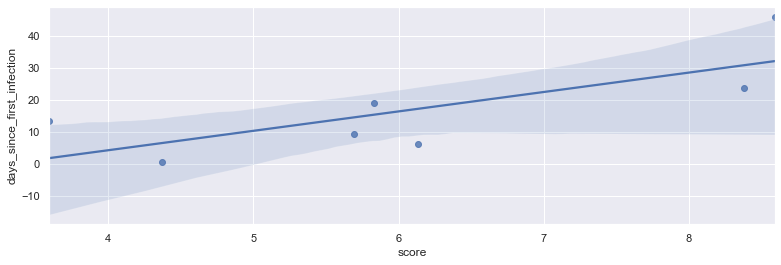

In [681]:
sns.regplot(data=df_merge.groupby("region").mean(), x="score", y="days_since_first_infection")

In [ ]:
df_merge[df_merge.region==""]

In [ ]:
# to do: cluster by regime type, do a regression model with a line for score vs. days_since_infection

# Works Cited

Florida Atlantic University. (2020, August 20). COVID-19: How South Korea prevailed while the United States failed. ScienceDaily. Retrieved November 13, 2020 from www.sciencedaily.com/releases/2020/08/200820102431.htm

Holshue, M.L., DeBolt, C., Lindquist, S., Lofy, K.H., Wiesman, J., Bruce, H., Spitters, C.L., Ericson, K., Wilkerson, S., Tural, A., Díaz, G.T., Cohn, A., Fox, L., Patel, A., Gerber, S., Kim, L., Tong, S., Lu, X., Lindstrom, S., Pallansch, M., Weldon, W., Biggs, H., Uyeki, T.M., & Pillai, S. (2020). First Case of 2019 Novel Coronavirus in the United States. The New England Journal of Medicine, 382, 929 - 936.

Lim, J., Jeon, S., Shin, H.Y., Kim, M.J., Seong, Y.M., Lee, W.J., Choe, K.W., Kang, Y.M., Lee, B., & Park, S.J. (2020). Case of the Index Patient Who Caused Tertiary Transmission of Coronavirus Disease 2019 in Korea: the Application of Lopinavir/Ritonavir for the Treatment of COVID-19 Pneumonia Monitored by Quantitative RT-PCR. Journal of Korean Medical Science, 35.

Mahdi, A., Blaszczyk, P., Dlotko, P., Salvi, D., Chan, T., Harvey, J., Gurnari, D., Wu, Y., Farhat, A., Hellmer, N., Zarebski, A., Hogan, B., & Tarassenko, L. (2020). OxCOVID19 Database: a multimodal data repository for better understanding the global impact of COVID-19. medRxiv.

The Economist Intelligence Unit. (2019). Democracy Index 2019. [online] Available at: <https://www.eiu.com/topic/democracy-index> [Accessed 13 November 2020].

You, J. (2020). Lessons From South Korea’s Covid-19 Policy Response. The American Review of Public Administration, 50, 801 - 808.